In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.decomposition import PCA
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.layers import Conv2D, Flatten, Conv1D
from tensorflow.keras.layers import Reshape, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from scipy.signal import lfilter
import solverFunctions as sf
import analysisFunctions as af
from scipy.interpolate import LinearNDInterpolator

In [2]:
def GetFlow(order_bc,continuous=False):
    if continuous:
        con_str = "C"
    else:
        con_str = "DC"
    u = np.load(r"DataDC/dataset"+con_str+"_u_30_1_"+str(order_bc)+".npy")
    v = np.load(r"DataDC/dataset"+con_str+"_v_30_1_"+str(order_bc)+".npy")
    p = np.load(r"DataDC/dataset"+con_str+"_p_30_1_"+str(order_bc)+".npy")
    return u,v,p

# data = list(zip(GetFlow(1),GetFlow(2),GetFlow(3),GetFlow(5),GetFlow(4,True)))
data = list(zip(GetFlow(1),GetFlow(2)))
# data = list(zip(GetFlow(4,True)))
u = np.concatenate(data[0],axis=0)
v = np.concatenate(data[1],axis=0)
p = np.concatenate(data[2],axis=0)
p = p-np.expand_dims(p.mean((1,2)),axis=(1,2))

def GetBoundary(u,v):
    u_n = (u[:,:,1:]+u[:,:,:-1])/2
    v_n = (v[:,1:,:]+v[:,:-1,:])/2
    u_bc = tf.concat([u_n[:,1:-1,0],u_n[:,-1,1:-1],u_n[:,1:-1,-1][:,::-1],u_n[:,0,1:-1][:,::-1]],axis=1)
    v_bc = tf.concat([v_n[:,1:-1,0],v_n[:,-1,1:-1],v_n[:,1:-1,-1][:,::-1],v_n[:,0,1:-1][:,::-1]],axis=1)
    return u_bc,v_bc

u_bc,v_bc = GetBoundary(u,v)

p.shape

(15176, 30, 30)

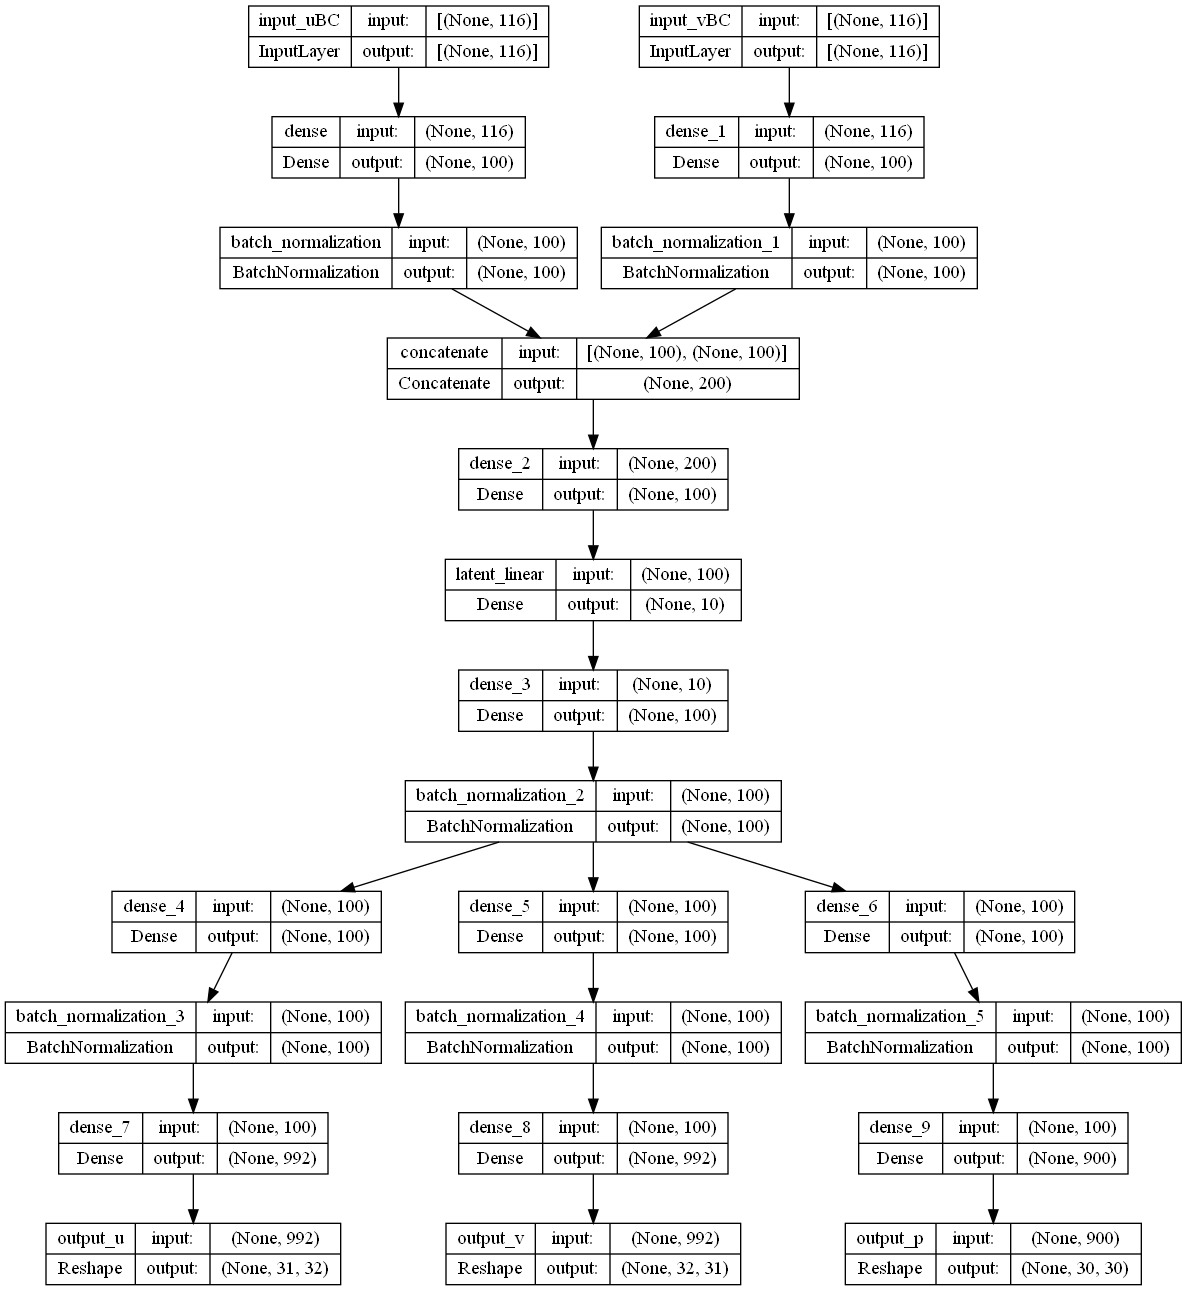

In [3]:
def GetEncoderStaggered(n_latent,input_shapes):
    input_u = Input(shape=input_shapes[0], name='input_uBC')
    input_v = Input(shape=input_shapes[1], name='input_vBC')
    x_u = Flatten()(input_u)
    x_v = Flatten()(input_v)
    x = Concatenate()([x_u,x_v])
    latent = Dense(n_latent)(x)
    encoder = Model([input_u,input_v],latent,name="encoder")
    return encoder,input_u,input_v,latent

def GetDecoderStaggered(n_latent,output_shapes,latent):
    # input_latent = Input(shape=(n_latent,))
    input_latent = latent
    output_u = Dense(np.prod(output_shapes[0]),use_bias=False)(input_latent)
    output_u = Reshape(output_shapes[0],name="output_u")(output_u)
    output_v = Dense(np.prod(output_shapes[1]),use_bias=False)(input_latent)
    output_v = Reshape(output_shapes[1],name="output_v")(output_v)
    output_p = Dense(np.prod(output_shapes[2]),use_bias=False)(input_latent)
    output_p = Reshape(output_shapes[2],name="output_p")(output_p)
    decoder = Model(input_latent,[output_u,output_v,output_p],name="decoder")
    return decoder,input_latent,output_u,output_v,output_p

def GetAEStaggered(input_shapes,output_shapes,n_latent):
    encoder,input_u,input_v,latent = GetEncoderStaggered(n_latent,input_shapes)
    decoder,input_latent,output_u,output_v,output_p = GetDecoderStaggered(n_latent,output_shapes,latent)
    model = Model([input_u,input_v], [output_u,output_v,output_p],name="model_staggered")
    
    return model, encoder, decoder

def GetEncoderStaggeredNL(n_latent,input_shapes,nodes):
    input_u = Input(shape=input_shapes[0], name='input_uBC')
    input_v = Input(shape=input_shapes[1], name='input_vBC')
    x_u,x_v = input_u,input_v

    for i in range(len(nodes[0])):
        x_u = Dense(nodes[0][i],activation='sigmoid')(x_u)
        x_u = BatchNormalization()(x_u)

        x_v = Dense(nodes[0][i],activation='sigmoid')(x_v)
        x_v = BatchNormalization()(x_v)
    
    x = Concatenate()([x_u,x_v])
    for i in range(len(nodes[1])):
        x = Dense(nodes[1][i],activation='sigmoid')(x)
        if (i < len(nodes[1])-1):
            x = BatchNormalization()(x)

    latent = Dense(n_latent,name='latent_linear')(x)
    encoder = Model([input_u,input_v],latent,name="encoder")
    return encoder,input_u,input_v,latent

def GetDecoderStaggeredNL(n_latent,output_shapes,latent,nodes):

    x = latent
    for i in range(len(nodes[1])-1,-1,-1):
        x = Dense(nodes[1][i],activation='sigmoid')(x)
        x = BatchNormalization()(x)

    x_u,x_v,x_p = x,x,x
    for i in range(len(nodes[0])-1,-1,-1):
        x_u = Dense(nodes[0][i],activation='sigmoid')(x_u)
        x_u = BatchNormalization()(x_u)

        x_v = Dense(nodes[0][i],activation='sigmoid')(x_v)
        x_v = BatchNormalization()(x_v)

        x_p = Dense(nodes[0][i],activation='sigmoid')(x_p)
        x_p = BatchNormalization()(x_p)
    
    output_u = Dense(np.prod(output_shapes[0]))(x_u)
    output_u = Reshape(output_shapes[0],name="output_u")(output_u)

    output_v = Dense(np.prod(output_shapes[1]))(x_v)
    output_v = Reshape(output_shapes[1],name="output_v")(output_v)

    output_p = Dense(np.prod(output_shapes[2]))(x_p)
    output_p = Reshape(output_shapes[2],name="output_p")(output_p)

    decoder = Model(latent,[output_u,output_v,output_p],name="decoder")
    return decoder,x,output_u,output_v,output_p

def GetAEStaggeredNL(input_shapes,output_shapes,n_latent,nodes=[[100,100],[100,100]]):
    encoder,input_u,input_v,latent = GetEncoderStaggeredNL(n_latent,input_shapes,nodes)
    decoder,input_latent,output_u,output_v,output_p = GetDecoderStaggeredNL(n_latent,output_shapes,latent,nodes)
    model = Model([input_u,input_v], [output_u,output_v,output_p],name="model_staggered")
    
    return model, encoder, decoder

n_latent = 10
input_shapes = (u_bc[0].shape,v_bc[0].shape)
output_shapes = (u[0].shape,v[0].shape,p[0].shape)
modelL, encoderL, decoderL = GetAEStaggeredNL(input_shapes,output_shapes,n_latent,nodes=[[100],[100]])
tf.keras.utils.plot_model(modelL, show_shapes=True)

In [7]:
def con_res_loss(u,v,prob):
    mp_e = prob.rho*prob.dy_p*u[:,1:,1:-1]
    mp_w = prob.rho*prob.dy_p*u[:,:-1,1:-1]
    mp_n = prob.rho*prob.dx_p*v[:,1:-1,1:]
    mp_s = prob.rho*prob.dx_p*v[:,1:-1,:-1]
    dmp = mp_w+mp_s-mp_e-mp_n
    con_res = tf.reduce_sum(tf.square(dmp),axis=(1,2))
    return con_res

def u_res_loss(u,v,p,prob):
    mu_e = prob.rho*prob.dy_u*(u[:,1:-1,1:-1]+u[:,2:,1:-1])/2
    mu_w = prob.rho*prob.dy_u*(u[:,:-2,1:-1]+u[:,1:-1,1:-1])/2
    mu_n = prob.rho*prob.dx_u*(v[:,1:-2,1:]+v[:,2:-1,1:])/2
    mu_s = prob.rho*prob.dx_u*(v[:,1:-2,:-1]+v[:,2:-1,:-1])/2
    convection = -(mu_e*(u[:,2:,1:-1]+u[:,1:-1,1:-1])/2\
    + mu_n*(u[:,1:-1,2:]+u[:,1:-1,1:-1])/2\
    - mu_w*(u[:,:-2,1:-1]+u[:,1:-1,1:-1])/2\
    - mu_s*(u[:,1:-1,:-2]+u[:,1:-1,1:-1])/2)
    diffusion = prob.Aud_x[:-1,:]*(u[:,1:-1,1:-1]-u[:,:-2,1:-1]) + prob.Aud_x[1:,:]*(u[:,1:-1,1:-1]-u[:,2:,1:-1]) +\
        prob.Aud_y[:,:-1]*(u[:,1:-1,1:-1]-u[:,1:-1,:-2]) + prob.Aud_y[:,1:]*(u[:,1:-1,1:-1]-u[:,1:-1,2:])
    pressure = prob.dy_u*(p[:,1:,:]-p[:,:-1,:])
    u_res = tf.reduce_sum(tf.square(convection-diffusion-pressure),axis=(1,2))
    return u_res

def v_res_loss(u,v,p,prob):
    mv_e = prob.rho*prob.dy_v*(u[:,1:,1:-2]+u[:,1:,2:-1])/2
    mv_w = prob.rho*prob.dy_v*(u[:,:-1,1:-2]+u[:,:-1,2:-1])/2
    mv_n = prob.rho*prob.dx_v*(v[:,1:-1,1:-1]+v[:,1:-1,2:])/2
    mv_s = prob.rho*prob.dx_v*(v[:,1:-1,1:-1]+v[:,1:-1,:-2])/2
    convection = -(mv_e*(v[:,2:,1:-1]+v[:,1:-1,1:-1])/2\
    + mv_n*(v[:,1:-1,2:]+v[:,1:-1,1:-1])/2\
    - mv_w*(v[:,:-2,1:-1]+v[:,1:-1,1:-1])/2\
    - mv_s*(v[:,1:-1,:-2]+v[:,1:-1,1:-1])/2)
    diffusion = prob.Avd_x[:-1,:]*(v[:,1:-1,1:-1]-v[:,:-2,1:-1]) + prob.Avd_x[1:,:]*(v[:,1:-1,1:-1]-v[:,2:,1:-1]) +\
        prob.Avd_y[:,:-1]*(v[:,1:-1,1:-1]-v[:,1:-1,:-2]) + prob.Avd_y[:,1:]*(v[:,1:-1,1:-1]-v[:,1:-1,2:])
    pressure = prob.dx_v*(p[:,:,1:]-p[:,:,:-1])
    # v_res_CV = (convection-diffusion-pressure)*(prob.dx_v*prob.dy_v)
    # v_res = tf.reduce_mean(tf.square(v_res_CV),axis=(1,2))
    v_res = tf.reduce_sum(tf.square(convection-diffusion-pressure),axis=(1,2))
    return v_res

def r_bc_lossF(x_bc,x_r,prob):
    u_r_bc, v_r_bc = GetBoundary(x_r[0],x_r[1])
    mse_u_bc = tf.reduce_mean(tf.square(x_bc[0]-u_r_bc),axis=1)
    mse_v_bc = tf.reduce_mean(tf.square(x_bc[1]-v_r_bc),axis=1)
    return mse_u_bc,mse_v_bc

def r_lossF(x,x_r,prob):
    reconstruction_u_loss = tf.reduce_sum(tf.square((x[0][:,1:-1,1:-1]-x_r[0][:,1:-1,1:-1])*(prob.dx_u*prob.dy_u)), axis=(1,2))
    reconstruction_v_loss = tf.reduce_sum(tf.square((x[1][:,1:-1,1:-1]-x_r[1][:,1:-1,1:-1])*(prob.dx_v*prob.dy_v)), axis=(1,2))
    reconstruction_p_loss = tf.reduce_sum(tf.square((x[2]-x_r[2])*(prob.dx_p*prob.dy_p)), axis=(1,2))
    return reconstruction_u_loss,reconstruction_v_loss,reconstruction_p_loss

def ae_loss_function(x,x_bc,x_r,r_weights,fd_weight,prob):
    # print(x_bc[0].shape)
    # print(x_r[0].shape)
    mse_u,mse_v,mse_p = r_lossF(x,x_r,prob)
    mse_u_bc,mse_v_bc = r_bc_lossF(x_bc,x_r,prob)
    r_loss = r_weights[0]*mse_u+r_weights[1]*mse_v+r_weights[2]*mse_p + r_weights[3]*mse_u_bc+r_weights[4]*mse_v_bc
    con_res = con_res_loss(x_r[0],x_r[1],prob)
    u_res = u_res_loss(x_r[0],x_r[1],x_r[2],prob)
    v_res = v_res_loss(x_r[0],x_r[1],x_r[2],prob)
    fd_loss = tf.math.log(con_res) + tf.math.log(u_res) + tf.math.log(v_res)
    loss = r_loss + fd_weight*fd_loss
    return loss, r_loss, fd_loss,[mse_u,mse_v,mse_p,mse_u_bc,mse_v_bc],[con_res,u_res,v_res]

@tf.function
# def train_step_VAE(x,r_weights,fd_weight,prob):
def train_step_VAE(model,optimizer,x_bc,x,r_weights,fd_weight,prob):
    with tf.GradientTape() as tape:
        
        x_r = model(x_bc,training=True)

        loss,r_loss,fd_loss,mse,res = ae_loss_function(x,x_bc,x_r,r_weights,fd_weight,prob)

    grads = tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(grads,model.trainable_variables))
    return loss,r_loss,fd_loss,mse,res

class History():
    def __init__(self,n):
        self.loss = np.zeros(n)
        self.r_loss = np.zeros(n)
        self.r_u_loss = np.zeros(n)
        self.r_v_loss = np.zeros(n)
        self.r_p_loss = np.zeros(n)
        self.r_u_bc_loss = np.zeros(n)
        self.r_v_bc_loss = np.zeros(n)
        self.l_loss = np.zeros(n)
        self.fd_loss = np.zeros(n)
        self.con_res = np.zeros(n)
        self.u_res = np.zeros(n)
        self.v_res = np.zeros(n)
        
    def add(self,history):
        self.loss = np.concatenate([self.loss,history.loss],axis=0)
        self.r_loss = np.concatenate([self.r_loss,history.r_loss],axis=0)
        self.r_u_loss = np.concatenate([self.r_u_loss,history.r_u_loss],axis=0)
        self.r_v_loss = np.concatenate([self.r_v_loss,history.r_v_loss],axis=0)
        self.r_p_loss = np.concatenate([self.r_p_loss,history.r_p_loss],axis=0)
        self.l_loss = np.concatenate([self.l_loss,history.l_loss],axis=0)
        self.fd_loss = np.concatenate([self.fd_loss,history.fd_loss],axis=0)

def train_VAE(model,optimizer,x_bc,x,n_epochs,n_batch,prob,r_weights=0.005,fd_weight=1,modelPath=None):
    n_steps = n_epochs#*len(range(0,x[0].shape[0],n_batch))
    history = History(n_steps)
    index = 0
    loss_min = np.inf
    x_bc[0] = tf.cast(x_bc[0],tf.float32)
    x_bc[1] = tf.cast(x_bc[1],tf.float32)

    x[0] = tf.cast(x[0],tf.float32)
    x[1] = tf.cast(x[1],tf.float32)
    x[2] = tf.cast(x[2],tf.float32)
    r_weights = tf.cast(r_weights,tf.float32)
    loss_epoch = np.zeros((x[0].shape[0]))
    r_loss_epoch = np.zeros((x[0].shape[0]))
    ru_loss_epoch = np.zeros((x[0].shape[0]))
    rv_loss_epoch = np.zeros((x[0].shape[0]))
    rp_loss_epoch = np.zeros((x[0].shape[0]))
    rubc_loss_epoch = np.zeros((x[0].shape[0]))
    rvbc_loss_epoch = np.zeros((x[0].shape[0]))
    fd_loss_epoch = np.zeros((x[0].shape[0]))
    con_res_epoch = np.zeros((x[0].shape[0]))
    u_res_epoch = np.zeros((x[0].shape[0]))
    v_res_epoch = np.zeros((x[0].shape[0]))

    
    for epoch in range(n_epochs):
        indices = tf.range(start=0, limit=tf.shape(x[0])[0], dtype=tf.int32)
        idx = tf.random.shuffle(indices)
        x_bc[0] = tf.gather(x_bc[0],idx)
        x_bc[1] = tf.gather(x_bc[1],idx)

        x[0] = tf.gather(x[0],idx)
        x[1] = tf.gather(x[1],idx)
        x[2] = tf.gather(x[2],idx)


        for batch in range(0,x[0].shape[0],n_batch):
            x_bc_batch = [x_bc[0][batch:batch+n_batch],x_bc[1][batch:batch+n_batch]]
            x_batch = [x[0][batch:batch+n_batch],x[1][batch:batch+n_batch],x[2][batch:batch+n_batch]]
            loss,r_loss,fd_loss,mse,res = train_step_VAE(model,optimizer,x_bc_batch,x_batch,r_weights,fd_weight,prob)
            # loss,r_loss,r_u_loss,r_v_loss,r_p_loss,fd_loss = train_step_VAE(x_batch,r_weights,fd_weight,prob)
            loss_epoch[batch:batch+loss.shape[0]] = loss
            r_loss_epoch[batch:batch+loss.shape[0]] = r_loss
            ru_loss_epoch[batch:batch+loss.shape[0]] = mse[0]
            rv_loss_epoch[batch:batch+loss.shape[0]] = mse[1]
            rp_loss_epoch[batch:batch+loss.shape[0]] = mse[2]
            rubc_loss_epoch[batch:batch+loss.shape[0]] = mse[3]
            rvbc_loss_epoch[batch:batch+loss.shape[0]] = mse[4]
            fd_loss_epoch[batch:batch+loss.shape[0]] = fd_loss
            con_res_epoch[batch:batch+loss.shape[0]] = res[0]
            u_res_epoch[batch:batch+loss.shape[0]] = res[1]
            v_res_epoch[batch:batch+loss.shape[0]] = res[2]
            # print(u_res_epoch[batch:batch+loss.shape[0]].mean())
            
            print("\r{}/{} epochs - {:.3g}%; loss = {:.5g}\t".format(epoch+1,n_epochs, 100*batch/x[0].shape[0],u_res_epoch.mean()),end="") #
        
        history.loss[index] = loss_epoch.mean()
        history.r_loss[index] = r_loss_epoch.mean()
        history.r_u_loss[index] = ru_loss_epoch.mean()
        history.r_v_loss[index] = rv_loss_epoch.mean()
        history.r_p_loss[index] = rp_loss_epoch.mean()
        history.r_u_bc_loss[index] = rubc_loss_epoch.mean()
        history.r_v_bc_loss[index] = rvbc_loss_epoch.mean()
        history.fd_loss[index] = fd_loss_epoch.mean()
        history.con_res[index] = con_res_epoch.mean()
        history.u_res[index] = u_res_epoch.mean()
        history.v_res[index] = v_res_epoch.mean()
        index+=1
            
        print("\r{}/{} epochs - {:.3g}%; loss = {:.5g}".format(epoch+1,n_epochs, 100,loss_epoch.mean()),end="\n")
        if (modelPath!=None) and (loss_epoch.mean()<loss_min):
            try:
                loss_min = loss_epoch.mean()
                model.save_weights(modelPath)
                print("model saved; loss = {}".format(loss_min))
            except:
                print("unable to save")
            
    return history

In [5]:
n_latent = 20
r_weights = [1/u.var(),1/v.var(),1/p.var(),1,1]
modelPath = "MLmodels/ModelsBC/NS_BC10D_150_150"
fd_weight = 0.0001
n_epochs = 30
n_batch = 128
x_bc = [u_bc,v_bc]
x = [u,v,p]
input_shapes = (u_bc[0].shape,v_bc[0].shape)
output_shapes = (u[0].shape,v[0].shape,p[0].shape)
prob = sf.GetProblem(30,1)

model, encoder, decoder = GetAEStaggeredNL(input_shapes,output_shapes,n_latent,nodes=[[150],[150]])
model.load_weights(modelPath)
optimizer = tf.keras.optimizers.Adam(0.001)
history = train_VAE(model,optimizer,x_bc,x,n_epochs,n_batch,prob,r_weights,fd_weight,modelPath)

1/30 epochs - 100%; loss = 0.02761607			
model saved; loss = 0.027616262211244403
2/30 epochs - 100%; loss = 0.02691617		
model saved; loss = 0.026916327516739925
3/30 epochs - 100%; loss = 0.02694195		
4/30 epochs - 100%; loss = 0.02712977		
5/30 epochs - 100%; loss = 0.02722878		
6/30 epochs - 100%; loss = 0.02732864		
7/30 epochs - 100%; loss = 0.02735604		
8/30 epochs - 100%; loss = 0.02696202		
9/30 epochs - 100%; loss = 0.02720649		
10/30 epochs - 100%; loss = 0.02693206		
11/30 epochs - 100%; loss = 0.02701543		
12/30 epochs - 100%; loss = 0.02712263		
13/30 epochs - 100%; loss = 0.02692796		
14/30 epochs - 100%; loss = 0.02677628		
model saved; loss = 0.02677550941288738
15/30 epochs - 100%; loss = 0.02701816		
16/30 epochs - 100%; loss = 0.02710257		
17/30 epochs - 100%; loss = 0.02709197		
18/30 epochs - 100%; loss = 0.02711694	
19/30 epochs - 100%; loss = 0.02729295		
20/30 epochs - 100%; loss = 0.02697143		
21/30 epochs - 100%; loss = 0.02750862		
22/30 epochs - 100%; loss 

In [8]:
n_latent = 20
r_weights = [1/u.var(),1/v.var(),1/p.var(),1,1]
# modelPathL = "MLmodels/ModelsBC/NS_BC10D__"
fd_weight = 0.0001
n_epochs = 50
n_batch = 128
x_bc = [u_bc,v_bc]
x = [u,v,p]
input_shapes = (u_bc[0].shape,v_bc[0].shape)
output_shapes = (u[0].shape,v[0].shape,p[0].shape)
prob = sf.GetProblem(30,1)

modelL, encoderL, decoderL = GetAEStaggered(input_shapes,output_shapes,n_latent)
# modelL.load_weights(modelPathL)
optimizer = tf.keras.optimizers.Adam(0.001)
historyL = train_VAE(modelL,optimizer,x_bc,x,n_epochs,n_batch,prob,r_weights,fd_weight)#modelPathL)

1/50 epochs - 100%; loss = 0.210293				
2/50 epochs - 100%; loss = 0.086489		
3/50 epochs - 100%; loss = 0.066409		
4/50 epochs - 100%; loss = 0.058252	
5/50 epochs - 100%; loss = 0.054532		
6/50 epochs - 100%; loss = 0.0528437	
7/50 epochs - 100%; loss = 0.0518982	
8/50 epochs - 100%; loss = 0.0512812	
9/50 epochs - 100%; loss = 0.0508269		
10/50 epochs - 100%; loss = 0.0504954		
11/50 epochs - 100%; loss = 0.0502675		
12/50 epochs - 100%; loss = 0.0500637		
13/50 epochs - 100%; loss = 0.0499106		
14/50 epochs - 100%; loss = 0.04976315	
15/50 epochs - 100%; loss = 0.04961212		
16/50 epochs - 100%; loss = 0.0494595			
17/50 epochs - 100%; loss = 0.04933218		
18/50 epochs - 100%; loss = 0.04924687	
19/50 epochs - 100%; loss = 0.04915978		
20/50 epochs - 100%; loss = 0.04911187		
21/50 epochs - 100%; loss = 0.04900733		
22/50 epochs - 100%; loss = 0.04893531		
23/50 epochs - 100%; loss = 0.04885234		
24/50 epochs - 100%; loss = 0.04878743		
25/50 epochs - 100%; loss = 0.04878287	
26/50 e

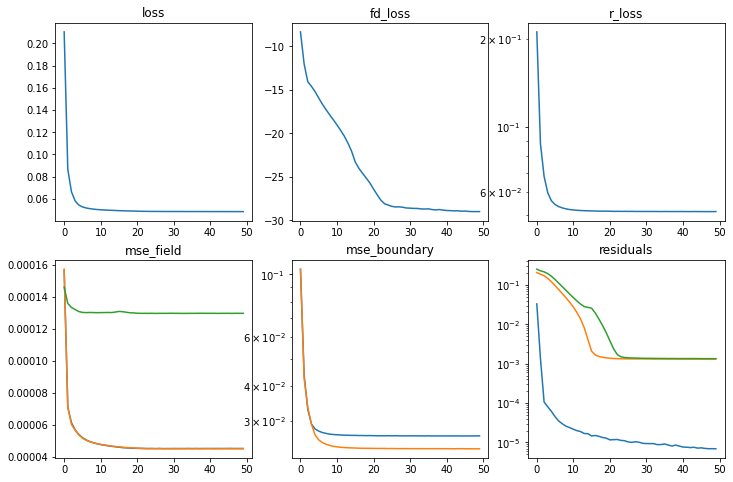

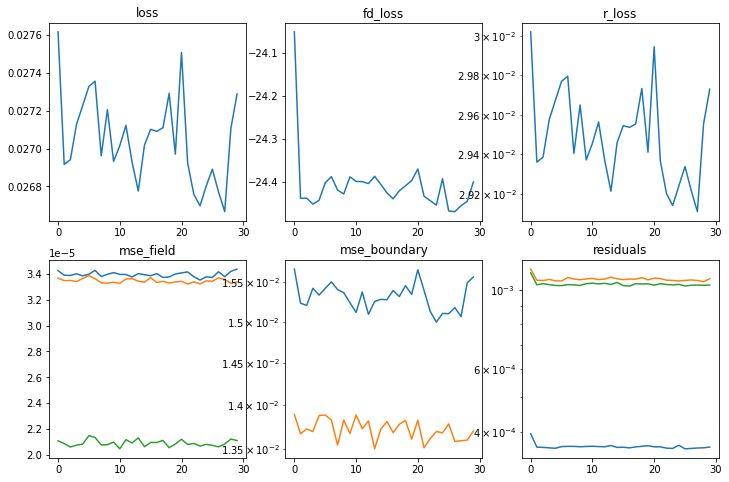

In [9]:

def plotHist(history,i_start = 0):
    plt.figure(figsize=(12,8))
    plt.subplot(2,3,1)
    plt.plot(history.loss[i_start:])
    plt.title("loss")
    plt.subplot(2,3,2)
    plt.plot(history.fd_loss[i_start:])
    plt.title("fd_loss")
    plt.subplot(2,3,3)
    plt.plot(history.r_loss[i_start:])
    plt.title("r_loss")
    plt.gca().set_yscale('log')
    plt.subplot(2,3,4)
    plt.plot(history.r_u_loss[i_start:])
    plt.plot(history.r_v_loss[i_start:])
    plt.plot(history.r_p_loss[i_start:])
    plt.title("mse_field")
    plt.subplot(2,3,5)
    plt.gca().set_yscale('log')
    plt.plot(history.r_u_bc_loss[i_start:])
    plt.plot(history.r_v_bc_loss[i_start:])
    plt.title("mse_boundary")
    plt.gca().set_yscale('log')
    plt.subplot(2,3,6)
    plt.plot(history.con_res[i_start:])
    plt.plot(history.u_res[i_start:])
    plt.plot(history.v_res[i_start:])
    plt.title("residuals")
    plt.gca().set_yscale('log')
    plt.show()

plotHist(historyL,0)
plotHist(history,0)


In [100]:
# u_r,v_r,p_r = modelL([u_bc,v_bc])
historyL.r_u_bc_loss

array([0.09126546, 0.03377094, 0.02493514, 0.02154256, 0.01969236])

In [209]:
tf.cast(u_r[0],tf.double)

<tf.Tensor: shape=(100, 31, 32), dtype=float64, numpy=
array([[[-0.05032384,  0.1959268 ,  0.26391634, ...,  0.21969062,
          0.26961002, -0.22453691],
        [ 0.07782129,  0.39484352,  0.23874299, ...,  0.24134882,
          0.2701107 ,  0.20851138],
        [ 0.10358015,  0.35672635,  0.24233428, ...,  0.24080309,
          0.21134791,  0.28941458],
        ...,
        [-0.21616982, -0.2863403 , -0.25642318, ..., -0.27112725,
         -0.25690073, -0.36883065],
        [-0.32307771, -0.2400953 , -0.30837697, ..., -0.30598307,
         -0.17361344, -0.44874221],
        [ 0.06981791, -0.29080424, -0.29490432, ..., -0.32108933,
         -0.31387594,  0.08725221]],

       [[ 0.13326623, -0.53132063, -0.5891878 , ...,  0.2127465 ,
          0.21921752,  0.00244238],
        [-0.44802409, -0.6684258 , -0.574471  , ...,  0.25175944,
          0.15965073,  0.26412144],
        [-0.5867117 , -0.5321185 , -0.57855928, ...,  0.25985736,
          0.07804813,  0.34622645],
        ...,

In [17]:
# def Evaluate(model,u_bc,v_bc,u,v,p,prob,reduce=True):
#     u_r,v_r,p_r = model([u_bc,v_bc])
#     # mse_u,mse_v,mse_p = tf.reduce_mean(tf.square(u-u_r),axis=(0,1,2)),tf.reduce_mean(tf.square(v-v_r),axis=(0,1,2)),tf.reduce_mean(tf.square(p-p_r),axis=(0,1,2))
#     mse_u = tf.sqrt(tf.reduce_sum(tf.square((u[:,1:-1,1:-1]-u_r[:,1:-1,1:-1])*(prob.dx_u*prob.dy_u)), axis=(1,2)))
#     mse_v = tf.sqrt(tf.reduce_sum(tf.square((v[:,1:-1,1:-1]-v_r[:,1:-1,1:-1])*(prob.dx_v*prob.dy_v)), axis=(1,2)))
#     mse_p = tf.sqrt(tf.reduce_sum(tf.square((p-p_r)*(prob.dx_p*prob.dy_p)), axis=(1,2)))
#     mse_u,mse_v = tf.sqrt(mse_u),tf.sqrt(mse_v)
#     u_res,v_res,con_res = u_res_loss(u_r,v_r,p_r,prob),v_res_loss(u_r,v_r,p_r,prob),con_res_loss(u_r,v_r,prob)
#     if reduce:
#         mse_u,mse_v,mse_p = tf.reduce_mean(mse_u),tf.reduce_mean(mse_v),tf.reduce_mean(mse_p)
#         u_res,v_res,con_res = tf.reduce_mean(u_res),tf.reduce_mean(v_res),tf.reduce_mean(con_res)
#     return mse_u.numpy(),mse_v.numpy(),mse_p.numpy(),u_res.numpy(),v_res.numpy(),con_res.numpy()

def Evaluate(model,u_bc,v_bc,u,v,p,prob,reduce=True):
    u_r,v_r,p_r = model([u_bc,v_bc])
    # mse_u,mse_v,mse_p = tf.reduce_mean(tf.square(u-u_r),axis=(0,1,2)),tf.reduce_mean(tf.square(v-v_r),axis=(0,1,2)),tf.reduce_mean(tf.square(p-p_r),axis=(0,1,2))
    mse_u,mse_v,mse_p = r_lossF([u,v,p],[u_r,v_r,p_r],prob)
    mse_u_bc, mse_v_bc = r_bc_lossF([u_bc,v_bc],[tf.cast(u_r,tf.double),tf.cast(v_r,tf.double),tf.cast(p_r,tf.double)],prob)
    mse_u,mse_v,mse_p = tf.sqrt(mse_u),tf.sqrt(mse_v),tf.sqrt(mse_p)
    u_res,v_res,con_res = u_res_loss(u_r,v_r,p_r,prob),v_res_loss(u_r,v_r,p_r,prob),con_res_loss(u_r,v_r,prob)
    if reduce:
        mse_u,mse_v,mse_p = tf.reduce_mean(mse_u),tf.reduce_mean(mse_v),tf.reduce_mean(mse_p)
        u_res,v_res,con_res = tf.reduce_mean(u_res),tf.reduce_mean(v_res),tf.reduce_mean(con_res)
    return mse_u.numpy(),mse_v.numpy(),mse_p.numpy(),u_res.numpy(),v_res.numpy(),con_res.numpy()

def ModelLoss(model,u_bc,v_bc,u,v,p,prob,r_weights,fd_weight,reduce=True):
    u_r,v_r,p_r = model([u_bc,v_bc])
    loss, r_loss,fd_loss,mse,res = ae_loss_function([u.astype(np.float32),v.astype(np.float32),p.astype(np.float32)],[u_bc.astype(np.float32),v_bc.astype(np.float32)],[u_r,v_r,p_r],r_weights,fd_weight,prob)
    if reduce:
        return loss.numpy().mean(),r_loss.numpy().mean(),fd_loss.numpy().mean()
    return loss.numpy(),r_loss.numpy(),fd_loss.numpy()

# r_weights = [1/u.var(),1/v.var(),1/p.var()]
# fd_weight = 0.00003

# mse_u,mse_v,mse_p,u_res,v_res,con_res = Evaluate(model,u_bc,v_bc,u,v,p,prob,True)
# print(mse_u,mse_v,mse_p,u_res,v_res,con_res)
# mse_u,mse_v,mse_p,u_res,v_res,con_res = Evaluate(modelL,u_bc,v_bc,u,v,p,prob,True)
# print(mse_u,mse_v,mse_p,u_res,v_res,con_res)
loss,r_loss,fd_loss = ModelLoss(model,u_bc,v_bc,u,v,p,prob,r_weights,fd_weight,reduce=True)
print(loss,r_loss,fd_loss)
# loss,r_loss,fd_loss = ModelLoss(modelL,u_bc,v_bc,u,v,p,prob,r_weights,fd_weight,reduce=True)
# print(loss,r_loss,fd_loss)

ResourceExhaustedError: Exception encountered when calling layer "dense_19" (type Dense).

OOM when allocating tensor with shape[15176,900] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:BiasAdd]

Call arguments received by layer "dense_19" (type Dense):
  • inputs=tf.Tensor(shape=(15176, 150), dtype=float32)

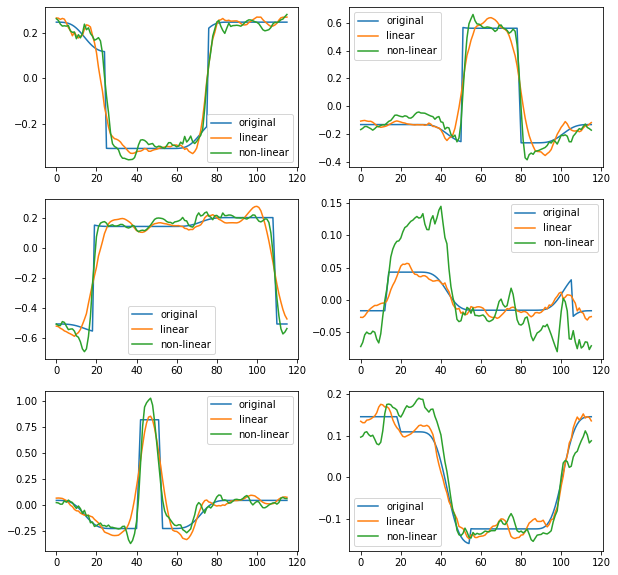

In [184]:
from re import L


def PlotFlow(u,v,prob,ax):
    X_n,Y_n = np.meshgrid(prob.xc_u,prob.yc_v)
    u_n = (u[:,:-1]+u[:,1:])/2
    v_n = (v[:-1,:]+v[1:,:])/2
    u_n = np.transpose(u_n)
    v_n = np.transpose(v_n)
    X,Y = np.meshgrid(np.linspace(0,1,u_n.shape[0]*2),np.linspace(0,1,u_n.shape[1]*2))
    points_n = np.concatenate([X_n.reshape(X_n.size,1),Y_n.reshape(Y_n.size,1)],axis=1)
    values_n = np.concatenate([u_n.reshape(u_n.size,1),v_n.reshape(v_n.size,1)],axis=1)
    interp = LinearNDInterpolator(points_n, values_n)
    values_i = interp(X,Y)
    u_c = values_i[:,:,0]
    v_c = values_i[:,:,1]
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])
    c = ax.pcolormesh(X,Y,np.sqrt(u_c**2+v_c**2))
    plt.colorbar(c)
    ax.streamplot(X,Y,u_c,v_c,color="k",linewidth=2,density=1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().axes.xaxis.set_visible(False)
    plt.gca().axes.yaxis.set_visible(False)


def Compare(n,models,u_bc,v_bc,u,v,p,prob):
    n = min(n,u.shape[0])
    m = len(models)
    x_r = []

    for i in range(len(models)):
        x_r.append(models[i]([u_bc[:n],v_bc[:n]]))
        x_r[i] = [x_r[i][0].numpy(),x_r[i][1].numpy(),x_r[i][2].numpy()]
    u_r,v_r,p_r = zip(*x_r)
    print(u_r[0].shape)
    mse = []
    for i in range(len(models)):
        mse.append(r_lossF([u[:n],v[:n],p[:n]],[u_r[i],v_r[i],p_r[i]],prob))
    mse_u,mse_v,mse_p = zip(*mse)

    plt.figure(figsize=(12,4*n))
    for i in tqdm(range(n)):
        ax = plt.subplot(n,m+1,(m+1)*i+1)
        PlotFlow(u[i],v[i],prob,ax)
        ax.title.set_text("con={:.3g}\nmom={:.3g}; {:.3g}".format(float(u_res_loss(u[i:i+1],v[i:i+1],p[i:i+1],prob)),float(v_res_loss(u[i:i+1],v[i:i+1],p[i:i+1],prob)),float(con_res_loss(u[i:i+1],v[i:i+1],prob))))
        for j in range(m):
            ax = plt.subplot(n,m+1,(m+1)*i+2+j)
            PlotFlow(u_r[j][i],v_r[j][i],prob,ax)
            ax.title.set_text("con={:.3g}\nmom={:.3g}; {:.3g}\n{:.3g}; {:.3g}; {:.3g}".format(float(u_res_loss(u_r[j][i:i+1],v_r[j][i:i+1],p_r[j][i:i+1],prob)),float(v_res_loss(u_r[j][i:i+1],v_r[j][i:i+1],p_r[j][i:i+1],prob)),float(con_res_loss(u_r[j][i:i+1],v_r[j][i:i+1],prob)),np.sqrt(mse_u[j][i]),np.sqrt(mse_v[j][i]),np.sqrt(mse_p[j][i])))
    plt.show()

def CompareBC(n,models,u_bc,v_bc,prob):
    n = min(n,u_bc.shape[0])
    m = len(models)
    x_r = []

    for i in range(m):
        x_r.append(models[i]([u_bc[:n],v_bc[:n]]))
        x_r[i] = [x_r[i][0].numpy(),x_r[i][1].numpy(),x_r[i][2].numpy()]
    u_r,v_r,p_r = zip(*x_r)
    x_bc_r = []
    for i in range(m):
        x_bc_r.append(GetBoundary(u_r[i],v_r[i]))
        x_bc_r[i] = [x_bc_r[i][0].numpy(),x_bc_r[i][1].numpy()]
    
    u_bc_r,v_bc_r = zip(*x_bc_r)

    plt.figure(figsize=(10,10))
    for i in range(n):
        ax = plt.subplot(n,2,2*i+1)
        ax.plot(u_bc[i])
        for j in range(m):
            ax.plot(u_bc_r[j][i])
        ax.legend(["original","linear","non-linear"])
        ax = plt.subplot(n,2,2*i+2)
        ax.plot(v_bc[i])
        for j in range(m):
            ax.plot(v_bc_r[j][i])
        ax.legend(["original","linear","non-linear"])
    plt.show()


i = 10010
# Compare(3,[modelL,modelL],u_bc[i:],v_bc[i:],u[i:],v[i:],p[i:],prob)
CompareBC(3,[modelL,model],u_bc[:100],v_bc[:100],prob)

In [121]:
models = [modelL,modelL]
x_r = []
n = 100
for i in range(len(models)):
    x_r.append(models[i]([u_bc[:n],v_bc[:n]]))
    x_r[i] = [x_r[i][0].numpy(),x_r[i][1].numpy(),x_r[i][2].numpy()]



(100, 31, 32)

In [131]:
u_r,v_r,p_r = zip(*x_r)

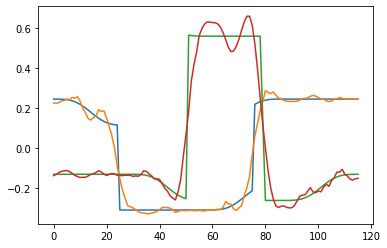

In [143]:
x_r = modelL([u_bc,v_bc])
u_bc_r,v_bc_r = GetBoundary(x_r[0],x_r[1])

plt.plot(u_bc[0])
plt.plot(u_bc_r[0])
plt.plot(v_bc[0])
plt.plot(v_bc_r[0])